# Time Series - Part 3 Forecasting 
In this notebook, we are going to discuss how to evaluate the forecasting models we discussed during the course so far.

The content of this notebook is based on
* Rob J Hyndman and George Athanasopoulos. Forecasting: Principles and Practice available at https://otexts.com/fpp2/

## Training and Test Evaluation
We cannot evaluate the forecast accuracy of a model on the same data we used to build it. The diagnostics over the residuals is a useful tool to analyze the quality of the model but cannot provide an indication of the actual error on future forecast. We therefore need to split the available data into a training and testing set. The former is used to create the model, the latter is used to evaluate the model forecast accuracy on previously unseen data. 

In machine learning, the split is usually done by randomly selecting which data points will be used for training and for testing. Time series are sequential, we train from the past to forecast the future accordingly we split the data according to its time line. The diagram below from [Hyndman & Athanasopoulos] shows an example of train/test split.

![TrainTestFromHyndman](images/hyndman_traintest.png "Training/testing split (from Rob J Hyndman and George Athanasopoulos: Forecasting: Principles and Practice).")

The size of the test set depends on our forecasting goals and should be at least as large as the maximum forecast horizon you are considering.

In a data-series there is a temporal relation between samples.

## Time Series Cross-Validation
Evaluating a model based on just one train/test partition can be biased by the selection of the data points belonging to each set. Cross-validation provides a more robust evaluation by providing an average performance over a sequence of models evaluated over more train/test partitions. The diagram below from [Hyndman & Athanasopoulos](https://otexts.com/fpp2/accuracy.html) show the series of training and test sets used for crossvalidation. The forecast accuracy is computed as the average test performance over all the test sets. 

![TrainTestFromHyndman](images/hyndman_cv.png "Time series crossvalidation for one-step ahead prediction (from Rob J Hyndman and George Athanasopoulos: Forecasting: Principles and Practice).")

Note that, we need to have enough data points to be able to compute a reliable forecast, accordingly, the earliest observations in the series are not considered as test sets. 

## Evaluation Metrics
The single forecast error is computed as the difference between the observed value and the correspoding predicted value, 

$$e_t = y_t - \hat{y}_t$$

To evaluate the forecast error over a set of data points we can compute the Mean Absolute Error (MAE) or the Root Mean Square Error (RMSE), 

MAE=$\frac{1}{N}\sum_t |e_t|$

RMSE=$\sqrt{\frac{1}{N}\sum_t e_t^2}$

Where $N$ is the number of data points in the test set. Note that errors are expressed in the same unit as the time series. Accordingly, MAE and RMSE and also scale dependent and cannot be used to compare predictions from different domains. We can make errors unit-free by considering their percentage with respect to the target value, that is,

$$p_t = 100 e_t/y_t$$

We can used $p_t$ to compute the Mean Absolute Percentage Error (MAPE) as the average of $p_t$, 

MAPE=$\frac{1}{N}\sum_t |p_t|$

Percentage errors are undefined when $y_t$ is zero or having extreme values when $y_t$ is close to zero. Accordingly, they should not be used when our time series has a meaningful zero value (e.g., temperature time series). In this cases, ther are other metrics like *scaled errors* (see [Hyndman & Athanasopoulos](https://otexts.com/fpp2/accuracy.html)). 

## Libraries and Data
We start by loading the required libraries and some data.

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# select the style from fivethityeight website
plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['axes.labelsize'] = 14
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

# predefined figsize
figsize=(12,9)

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
apple = pd.read_csv('stocks/2020/AAPL_2006-01-01_to_2020-05-01.csv', index_col='Date', parse_dates=['Date'])
google = pd.read_csv('stocks/2020/GOOGL_2006-01-01_to_2020-05-01.csv', index_col='Date', parse_dates=['Date'])
amazon = pd.read_csv('stocks/2020/AMZN_2006-01-01_to_2020-05-01.csv', index_col='Date', parse_dates=['Date'])
microsoft = pd.read_csv('stocks/2020/MSFT_2006-01-01_to_2020-05-01.csv', index_col='Date', parse_dates=['Date'])
boeing = pd.read_csv('stocks/2020/BA_2006-01-01_to_2020-05-01.csv', index_col='Date', parse_dates=['Date'])
all_stocks = pd.read_csv('stocks/2020/all_stocks_2006-01-01_to_2020-05-01.csv', index_col='Date', parse_dates=['Date'])
all_stocks = all_stocks.groupby('Date').mean()

stocks = google.Close[:'2020-02-01'].to_frame('GOOG')
stocks = stocks.join(amazon.Close[:'2020-02-01'].to_frame('AMZN'))
stocks = stocks.join(microsoft.Close[:'2020-02-01'].to_frame('MSFT'))
stocks = stocks.join(boeing.Close[:'2020-02-01'].to_frame('BA'))
stocks = stocks.join(apple.Close[:'2020-02-01'].to_frame('AAPL'))
stocks = stocks.join(all_stocks.Close[:'2020-02-01'].to_frame('ALL'))

For all the time series we also compute the percentage of change.

In [3]:
daily_returns = stocks.pct_change().dropna()

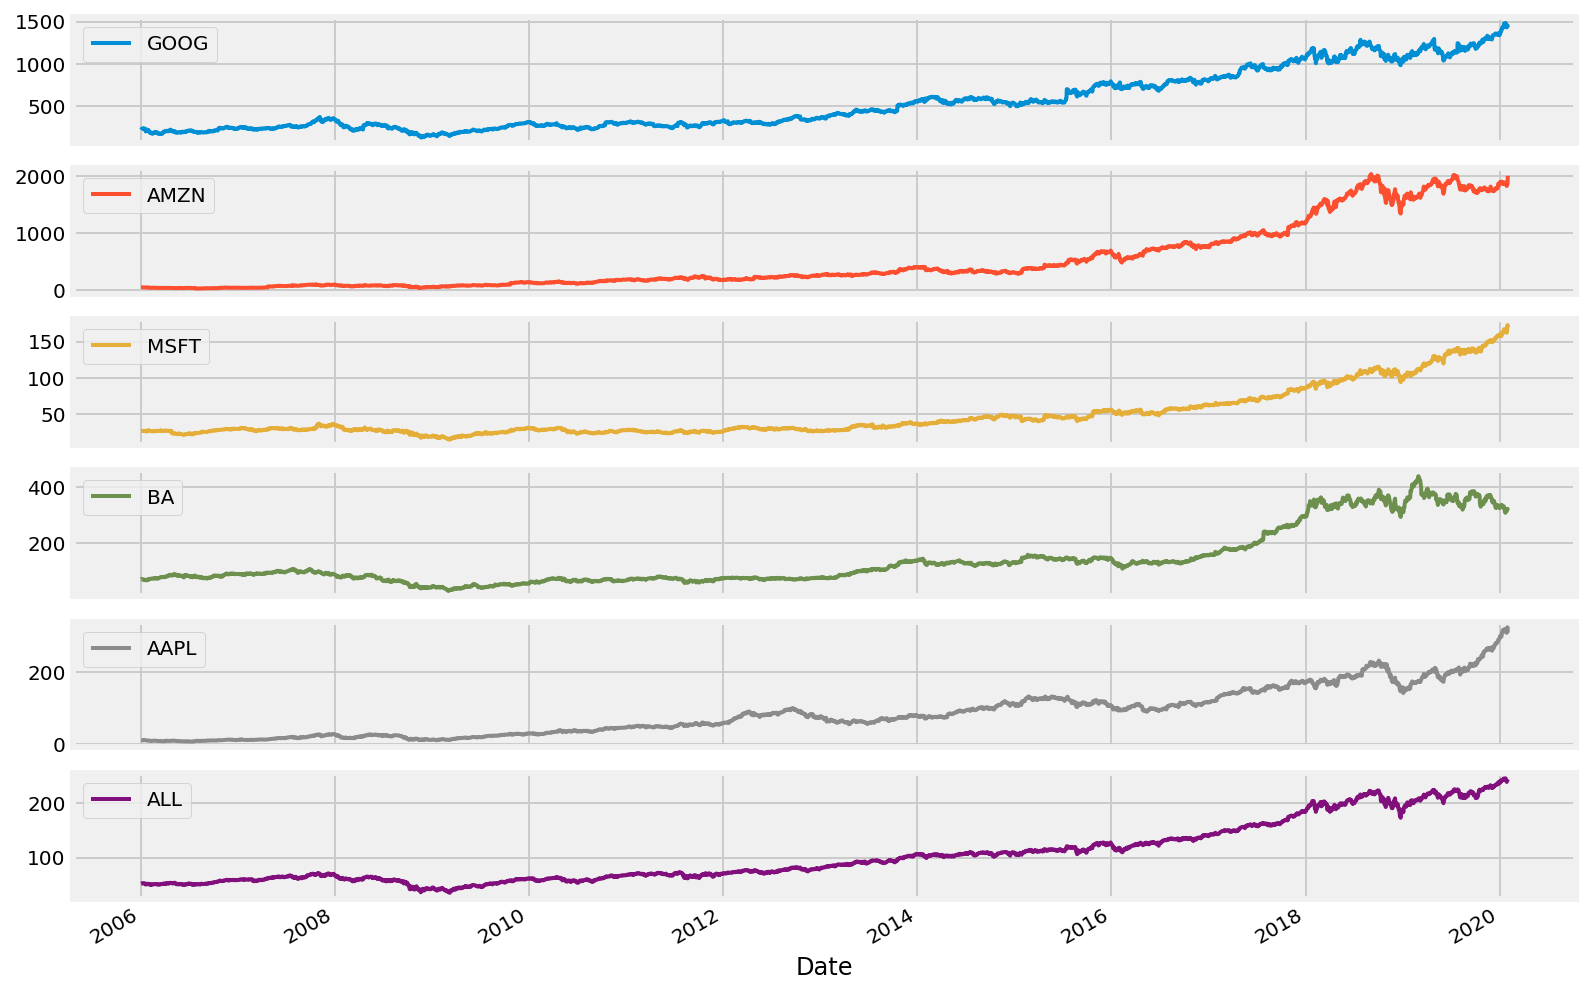

In [4]:
stocks.plot(figsize=figsize,subplots=True);

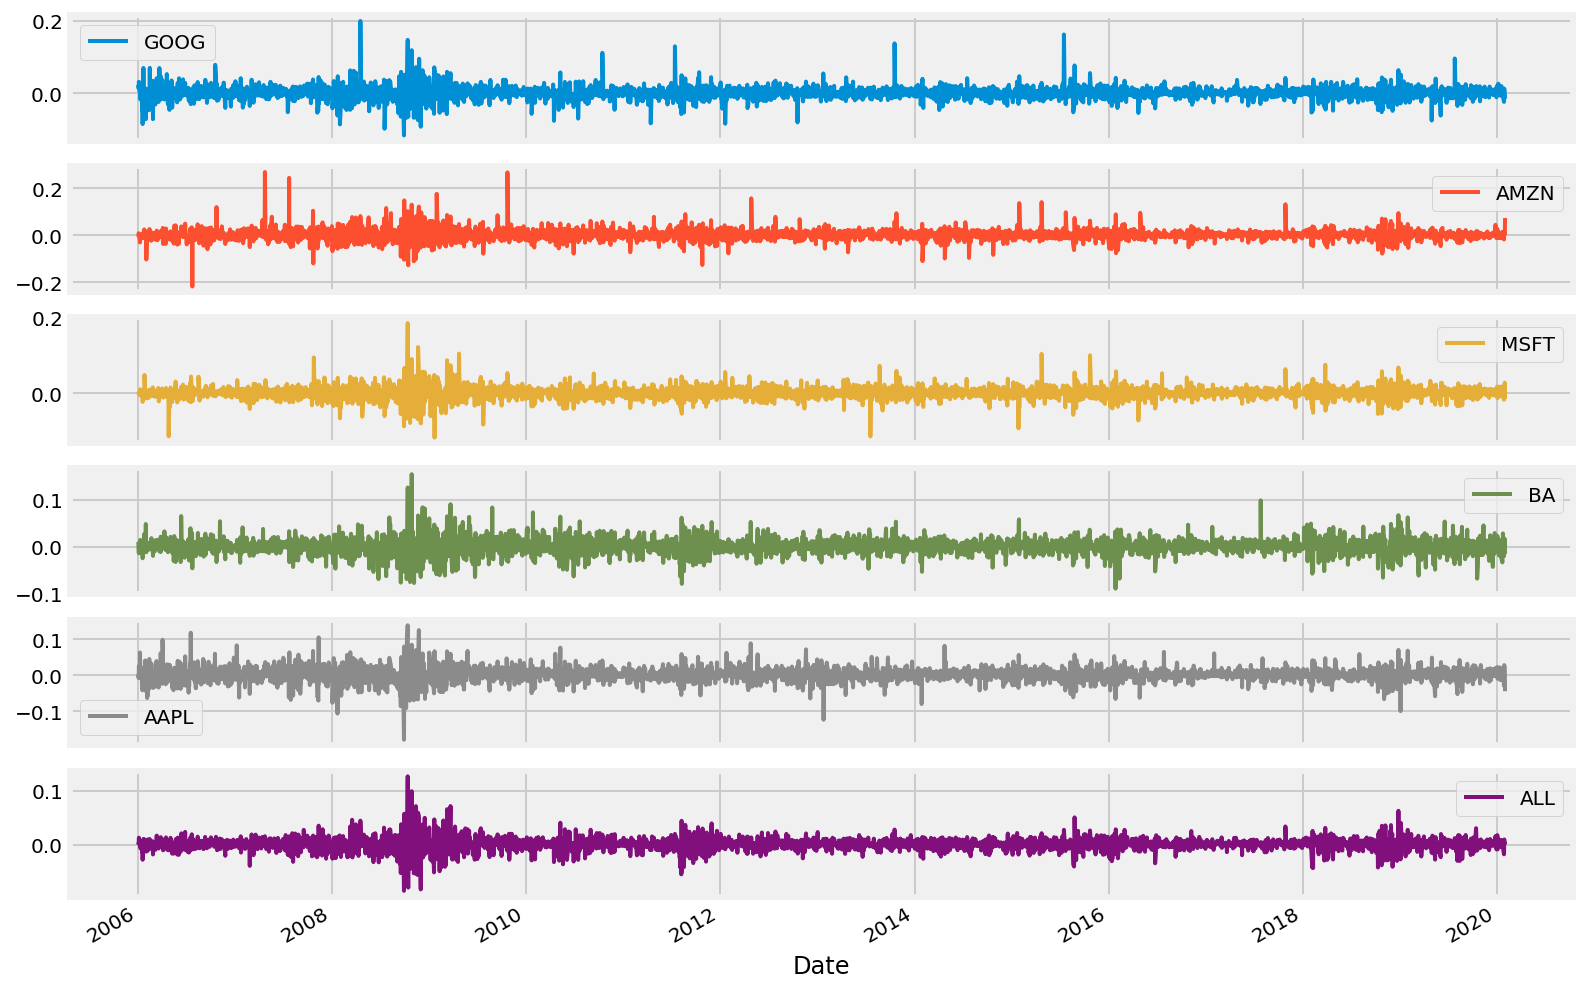

In [5]:
daily_returns.plot(figsize=figsize,subplots=True);

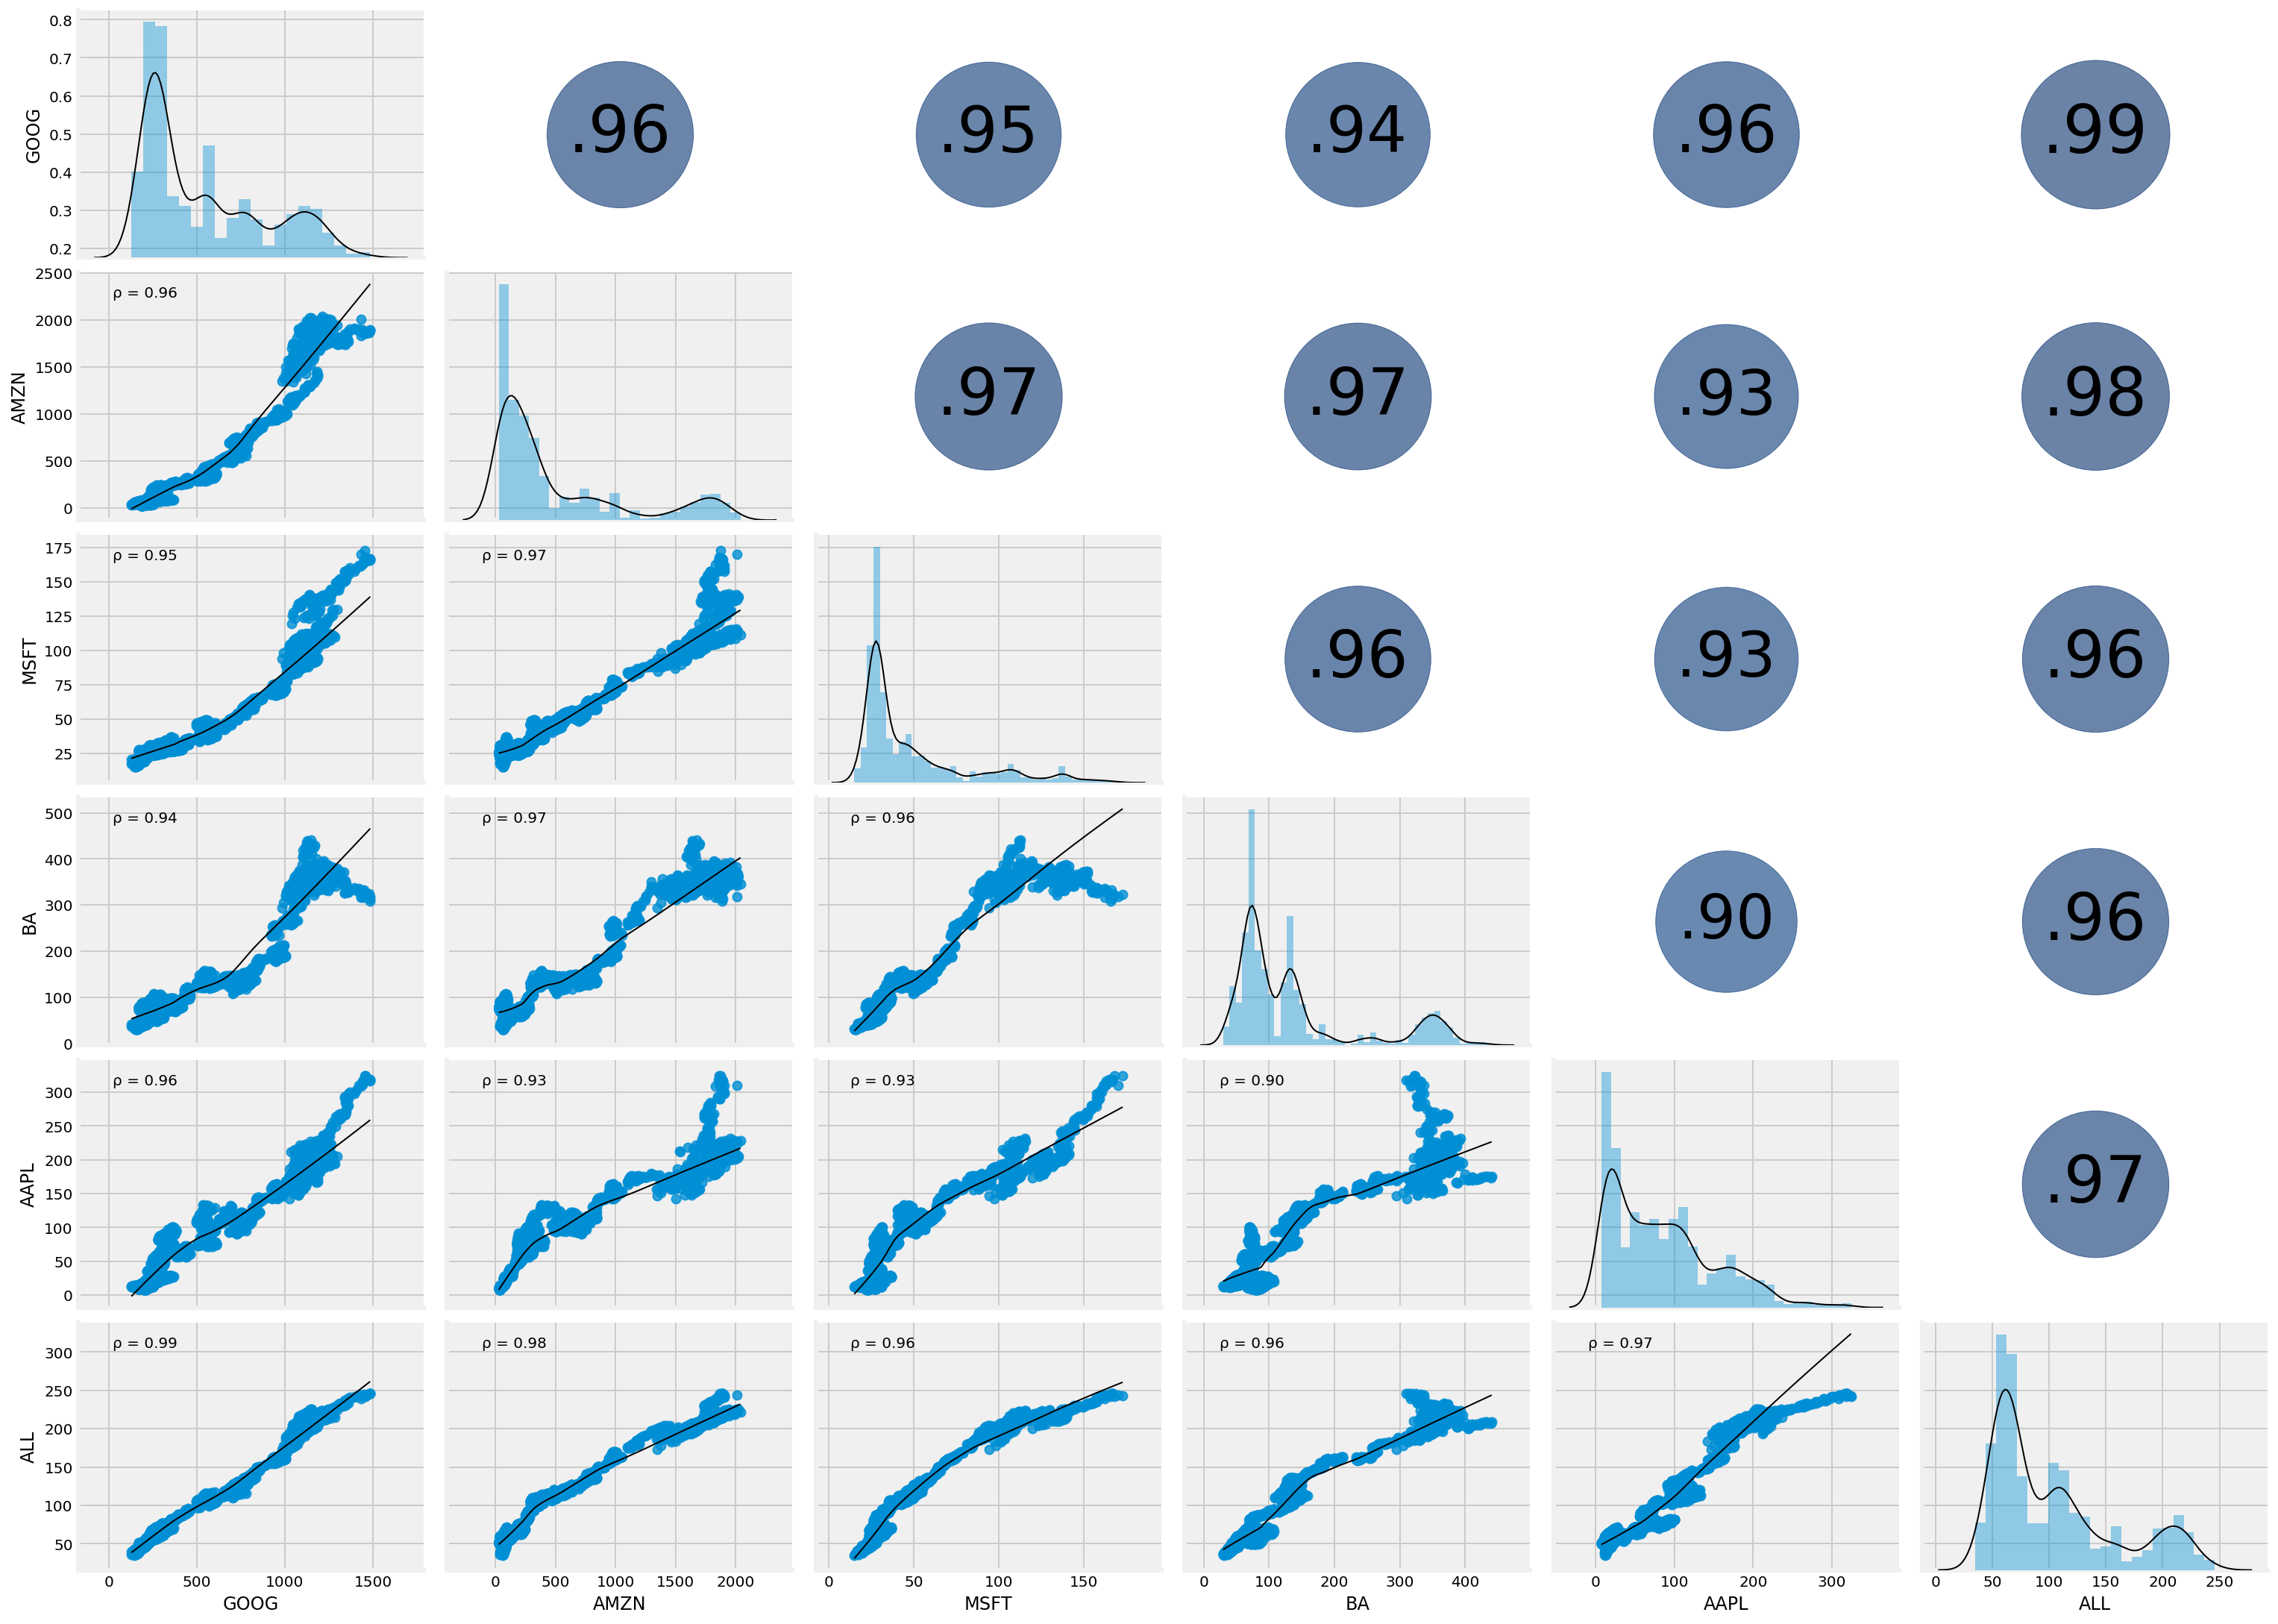

In [6]:
from scipy.stats import pearsonr

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="Blues",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)    
    
# g = sns.pairplot(stocks,palette=["Blues_d"])
g = sns.PairGrid(stocks, aspect=1.4, diag_sharey=False)
g.map_lower(corrfunc)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'Black','linewidth':1})
g.map_diag(sns.distplot, kde_kws={'color': 'Black','linewidth':1})
g.map_upper(corrdot)
plt.show()

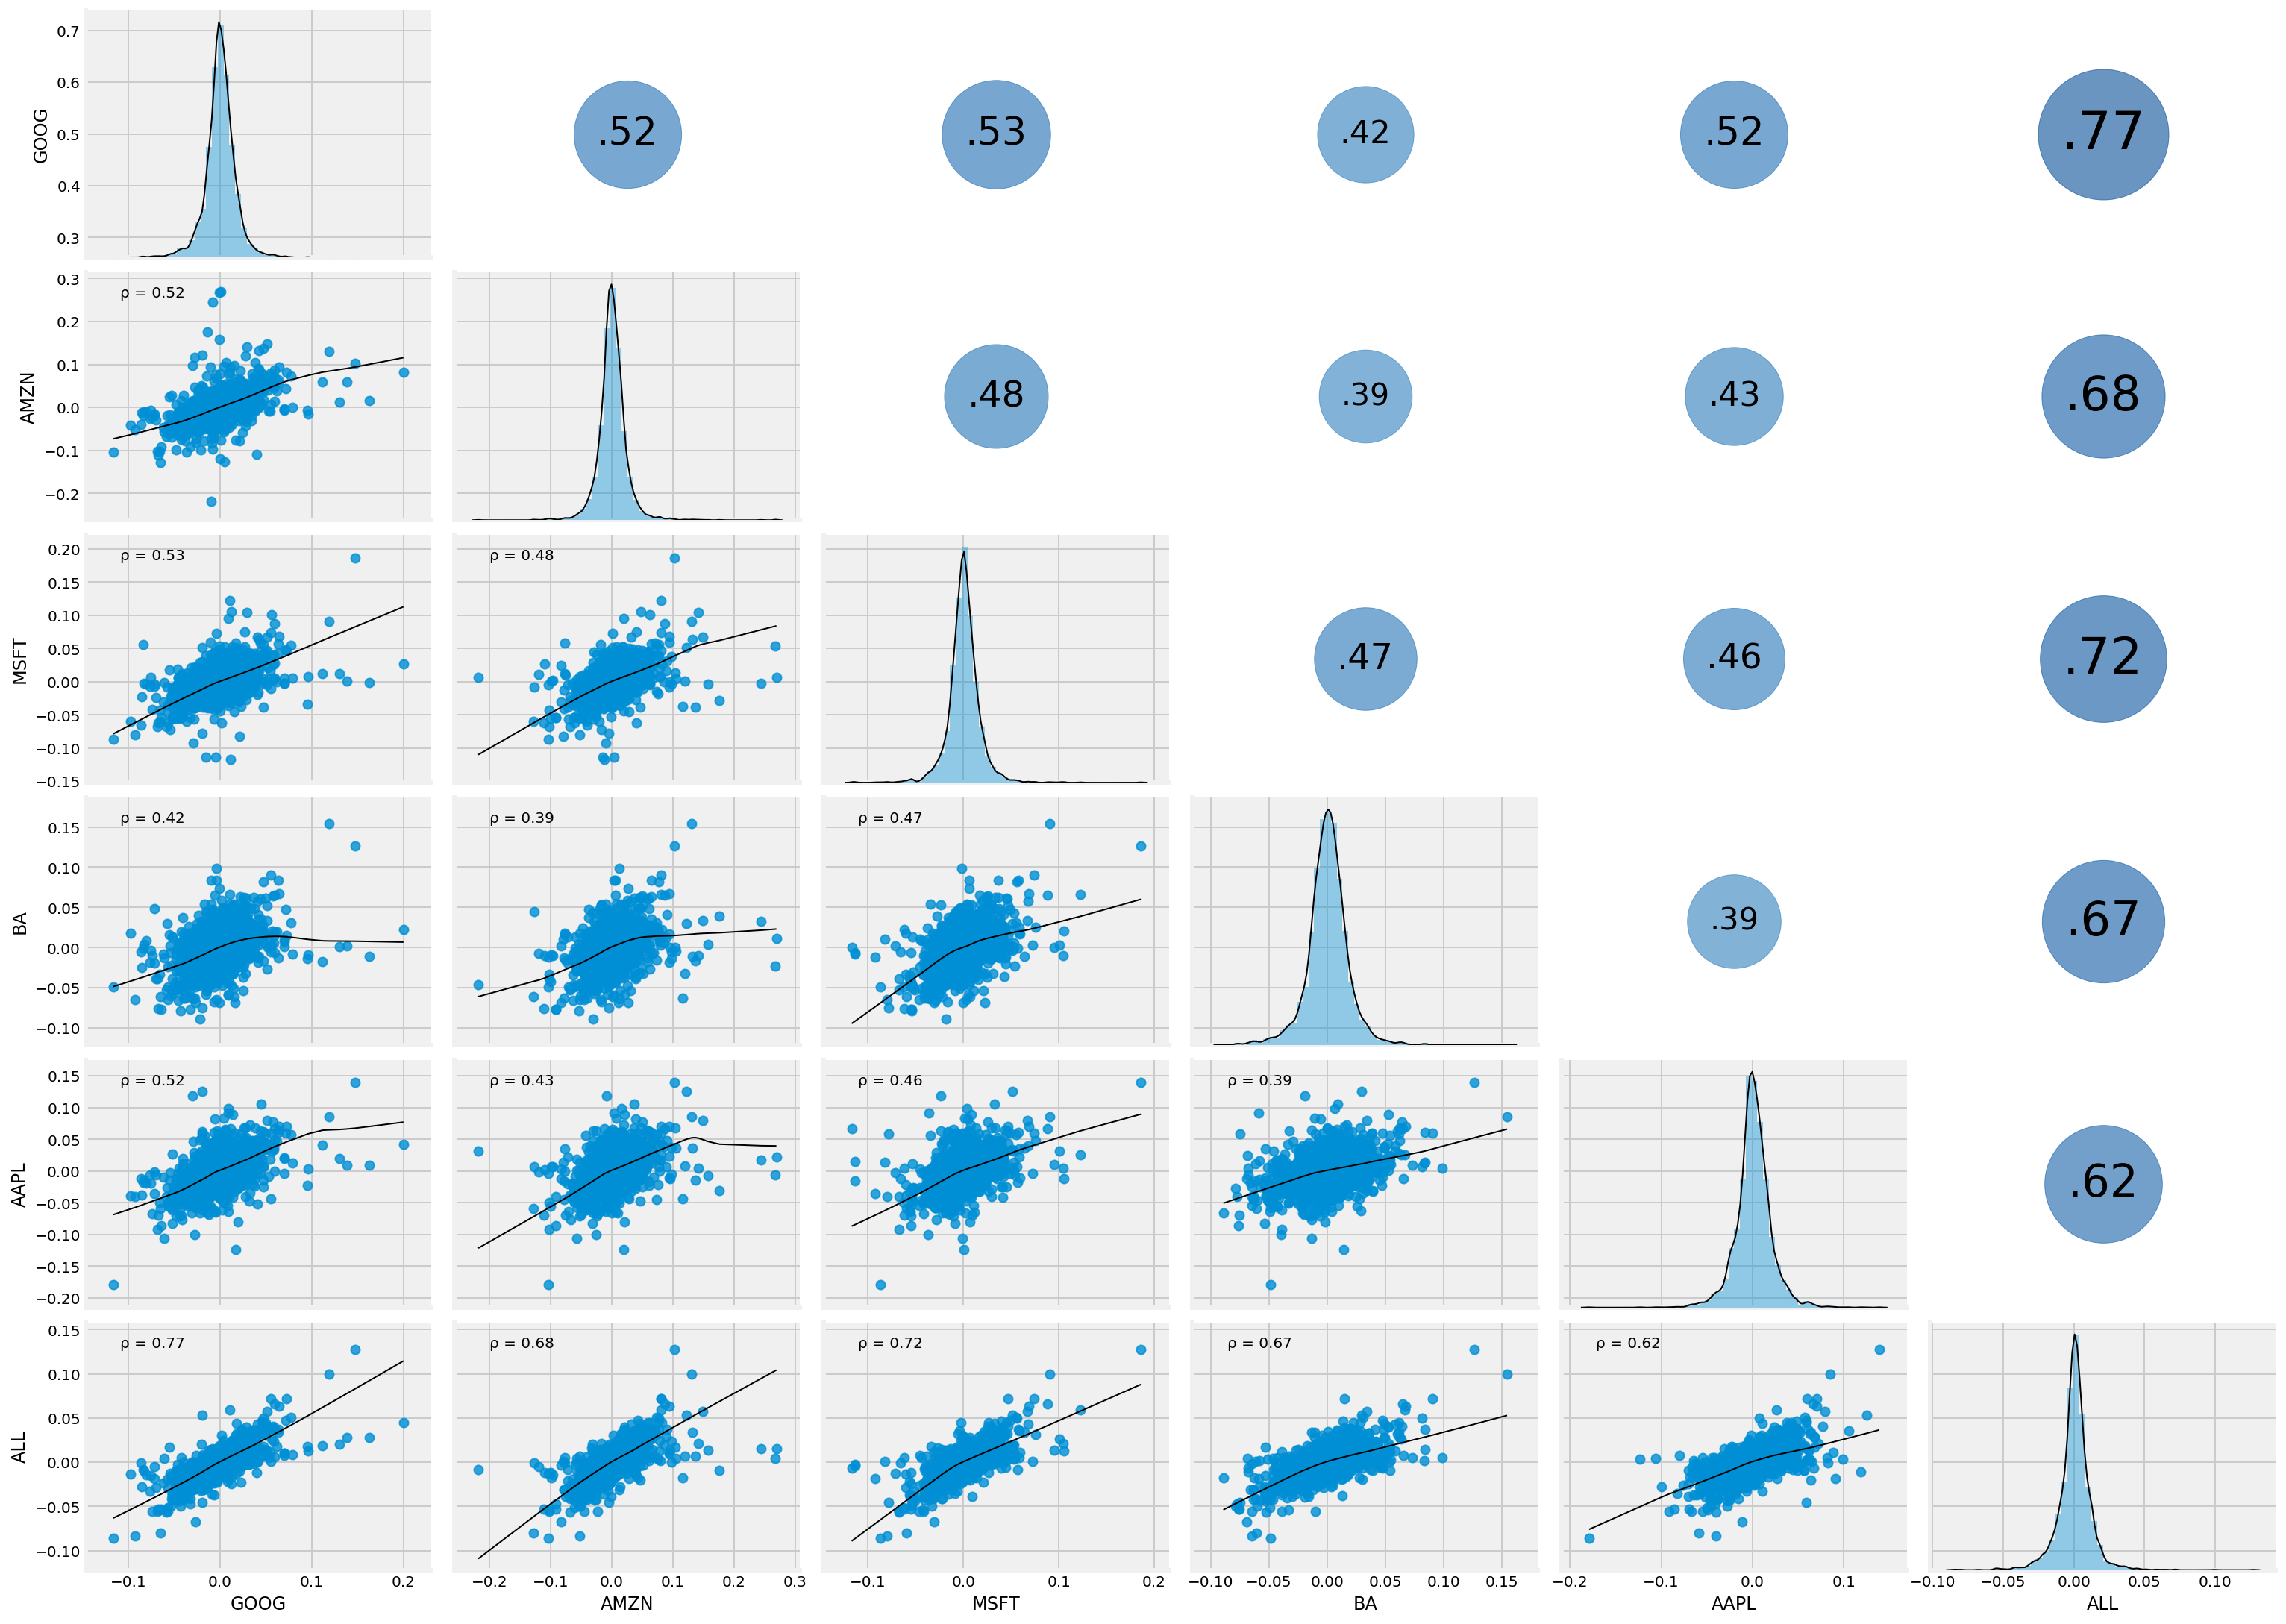

In [7]:
# g = sns.pairplot(stocks,palette=["Blues_d"])
g = sns.PairGrid(daily_returns, aspect=1.4, diag_sharey=False)
g.map_lower(corrfunc)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'Black','linewidth':1})
g.map_diag(sns.distplot, kde_kws={'color': 'Black','linewidth':1})
g.map_upper(corrdot)
plt.show()

In [8]:
def ADFuller(df):
    index = df.index
    columns = df.columns
    df_stats = pd.DataFrame(columns=['p-value'], index=columns)
    for col in columns:
        df_stats.loc[col] = adfuller(df[col], autolag='AIC')[1]
    return df_stats

In [9]:
ADFuller(stocks)

,p-value
GOOG,0.997167
AMZN,0.9984
MSFT,1
BA,0.968055
AAPL,0.998344
ALL,0.998924


In [10]:
ADFuller(daily_returns)

,p-value
GOOG,0
AMZN,0
MSFT,4.69474e-27
BA,4.71877e-24
AAPL,3.84738e-26
ALL,1.07457e-27


Since the p-value for *stocks* is 1, we cannot reject the null hypothesis that the series is a random walk. In contrast, the p-value for *daily_returns* is 0.0 so we can reject the null hypothesis (the series is not a random walk). 

## Linear Regression
We want to apply linear regression to build a model to forecast a stock. The traditional approaches discussed in the previous notebook (e.g., ARIMA(p,d,q)) directly work on the series estimate the best parameters for a target model (e.g., AR(p), MA(p), ARMA(p)) that estimates the current series value $y_t$ based on previous values $y_{t-k}$,  shock terms $\epsilon_{t-j}$, exogenous variables, etc.

Linear regression works on data points in which the value of a target variable is predicted based on the other (independent) variables. To apply linear regression we need to transform the single time series in a set of tuples that linear regression can manage. As the very first example we want to fit a simple linear model that will predict $y_t$ from $y_{t-1}$. 

In [11]:
# create a data frame from a stock series
df_stock = pd.DataFrame()
df_stock['t'] = stocks['AAPL']

# add the t-1 lag
df_stock['t-01'] = df_stock['t'].shift()

# eliminate the trailing NaN
df_stock.dropna(inplace=True)

In [12]:
df_stock

,t,t-01
Date,,
2006-01-04,10.710000,10.678572
2006-01-05,10.625714,10.710000
2006-01-06,10.900000,10.625714
2006-01-09,10.864285,10.900000
2006-01-10,11.551429,10.864285
...,...,...
2020-01-27,308.950012,318.309998
2020-01-28,317.690002,308.950012
2020-01-29,324.339996,317.690002


We now have a dataset similar to the ones used for linear regression in which each tuple is a training example. As usual, let's define the inputs as X and the target as y

In [13]:
target_variable = 't'
input_variables = df_stock.columns[df_stock.columns!=target_variable]

In [14]:
X = df_stock[input_variables]
y = df_stock[target_variable]

We need to split our data as training and test. We are going to use 2017-2018 for training and the first month of 2020 for testing. It is also better to check what the two sets actually look like. 

In [15]:
X_train, X_test = X['2017':'2019-10'], X['2019-10':]
y_train, y_test = y['2017':'2019-10'], y['2019-10':]

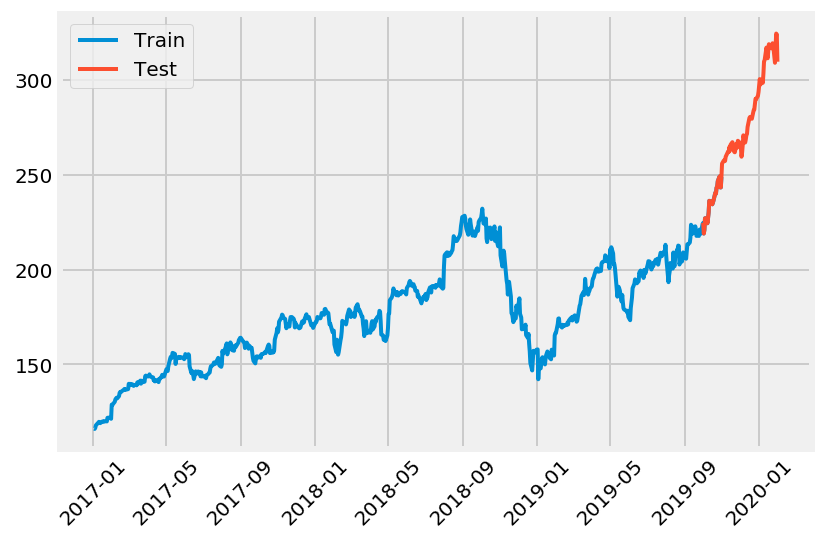

In [16]:
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Let's train our model and evaluate it on the test data.

In [17]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

yt = lr_model.predict(X_train)
yp = lr_model.predict(X_test)

print('RMSE on Test %.3f'%math.sqrt(mean_squared_error(yp, y_test)))

RMSE on Test 3.831


To compute the mean absolute percentage error, we define the following function,

In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
print('MAPE on Test %.3f'%mean_absolute_percentage_error(y_test, yp))

MAPE on Test 1.046


In [22]:
df_result_train = pd.DataFrame(y_train)
df_result_train['predicted'] = yt
df_result_test = pd.DataFrame(y_test)
df_result_test['predicted'] = yp

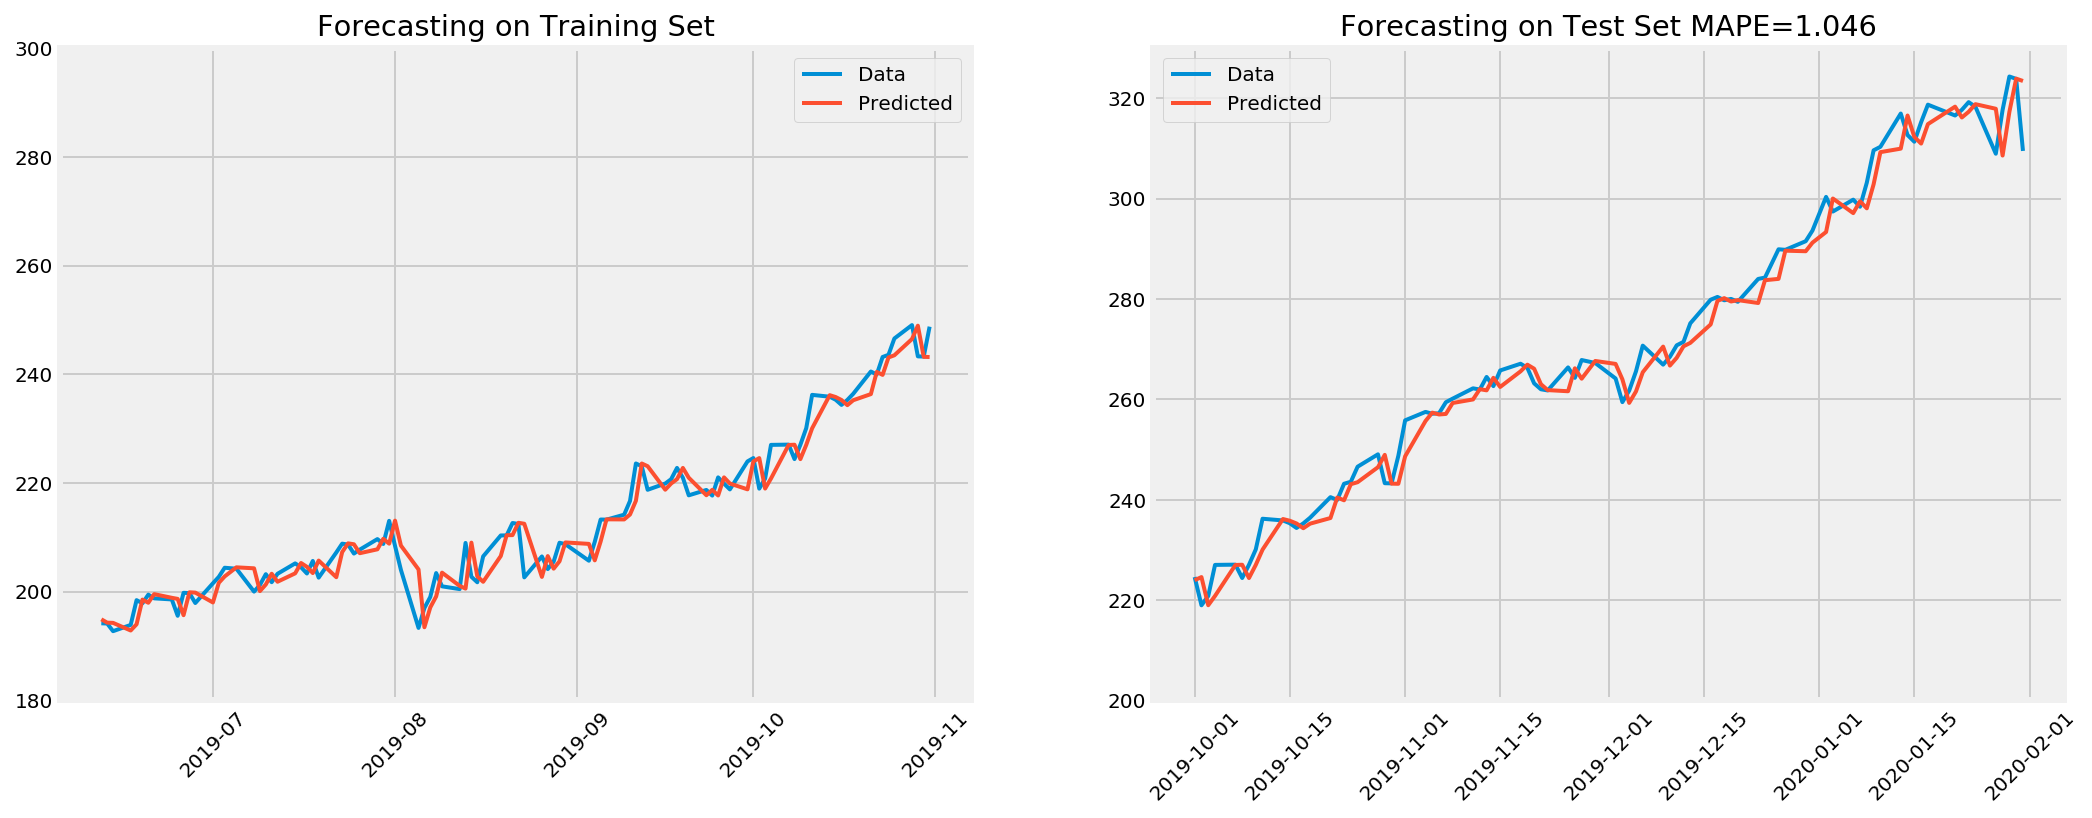

In [23]:
fig,axes = plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(df_result_train['t'][-100:],label='Data')
plt.plot(df_result_train['predicted'][-100:],label='Predicted')
plt.ylim([180,300])
plt.xticks(rotation=45)
plt.title("Forecasting on Training Set")
plt.legend();

plt.subplot(1,2,2)
plt.plot(df_result_test['t'],label='Data')
plt.plot(df_result_test['predicted'],label='Predicted')
plt.ylim([200,330])
plt.xticks(rotation=45)
plt.title("Forecasting on Test Set MAPE=%.3f"%mean_absolute_percentage_error(y_test,yp))
plt.legend();

We can improve the model by adding more information. For instance, we can add more lags (for example from t-1 to t-10) and then we might also add some differences at different intervals rolling window average. We define a function to help us adding all the variables.

In [25]:
def add_variables(df, target_variable, lags=0, diffs=[], rolling_windows=[]):
    df_forecasting = pd.DataFrame(df[target_variable])
    
    # add the lags
    if (lags>0):
        for i in range(1,lags+1):
            df_forecasting[target_variable+'-%02d'%i] = df_forecasting[target_variable].shift(i)

    if ((target_variable+'-01') in df_forecasting.columns):
        for diff in diffs:
            df_forecasting[target_variable+'-diff%d'%diff] = df_forecasting[target_variable+'-01'].diff(diff)
                
        for window in rolling_windows:
            df_forecasting["t-01-rw"+str(window)] = df_forecasting["t-01"].rolling(window = window).mean()

    df_forecasting.dropna(inplace=True)
    
    return df_forecasting

In [26]:
# create a data frame from a stock series
df_stock = pd.DataFrame()
df_stock['t'] = stocks['AAPL']

df_stock = add_variables(df_stock, 't', lags=10, diffs=[1,7,14], rolling_windows=[5,10,15])

We can now repeat the same procedure with the new enriched dataset. In this case, we apply Lasso and check also what features are the selected by the model.

RMSE on Test 3.784
MAPE on Test 1.042


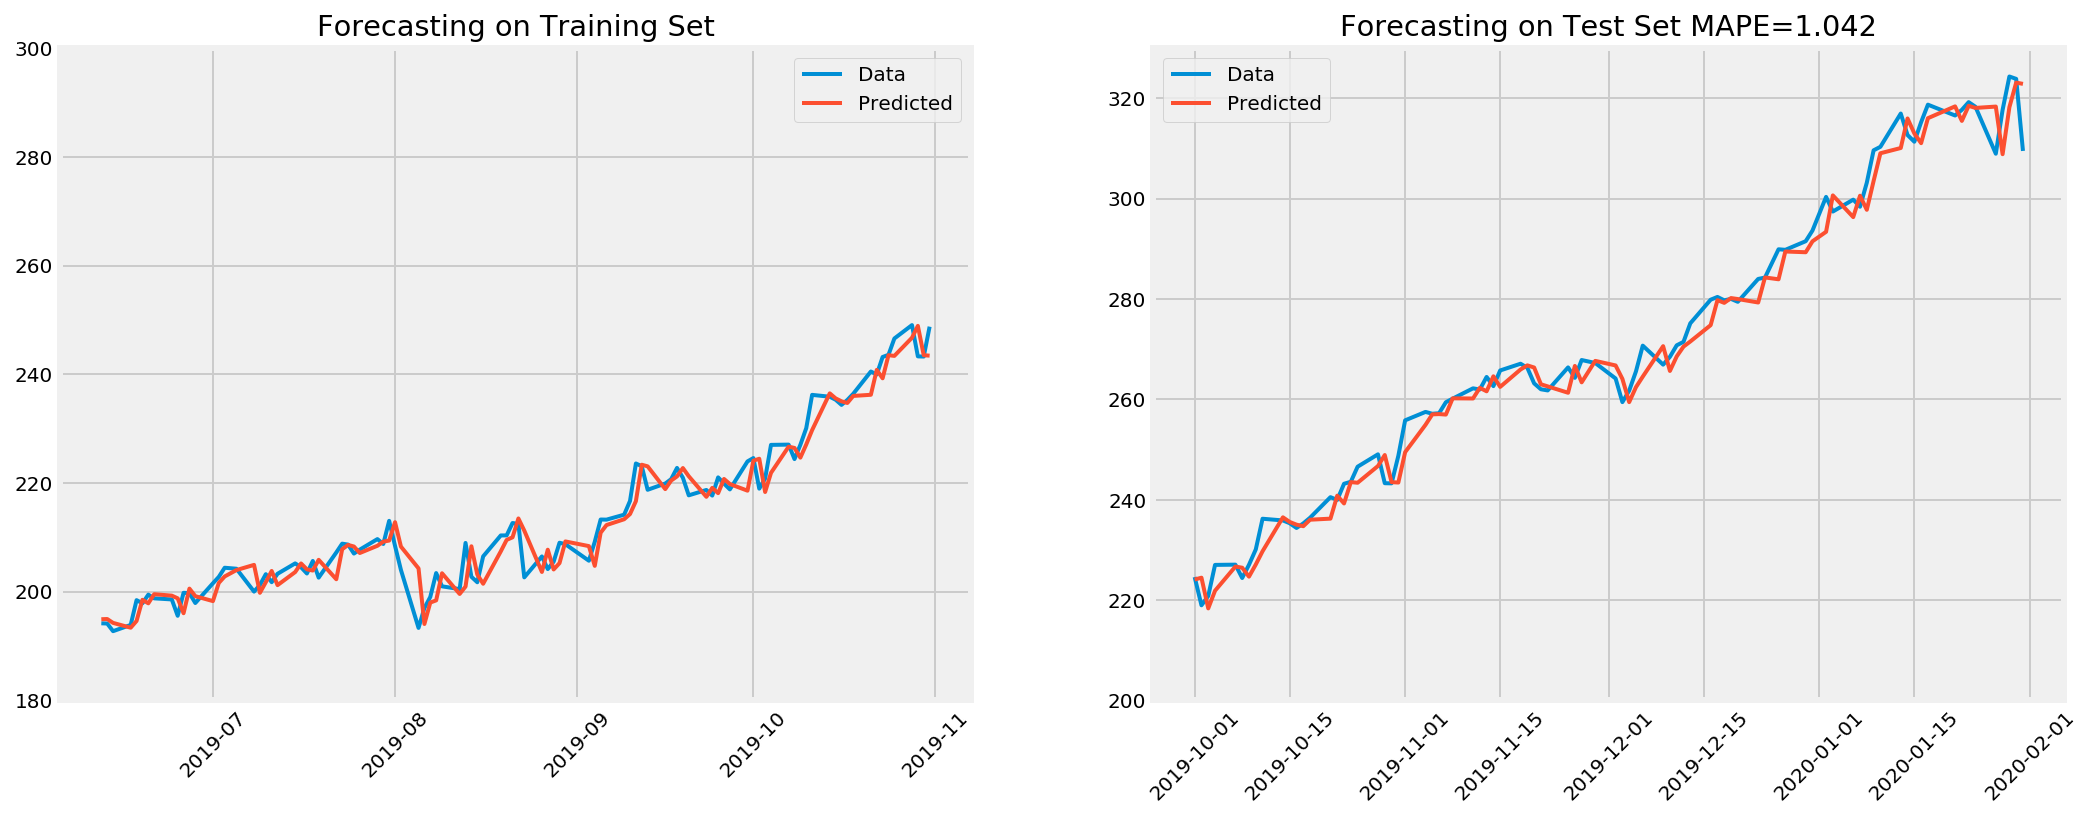

In [27]:
target_variable = 't'
input_variables = df_stock.columns[df_stock.columns!=target_variable]

X=df_stock[input_variables]
y=df_stock[target_variable]

X_train, X_test = X['2017':'2019-10'], X['2019-10':]
y_train, y_test = y['2017':'2019-10'], y['2019-10':]

lr_model = Lasso(alpha=0.01)
lr_model.fit(X_train, y_train)

yt = lr_model.predict(X_train)
yp = lr_model.predict(X_test)

print('RMSE on Test %.3f'%math.sqrt(mean_squared_error(yp, y_test)))
print('MAPE on Test %.3f'%mean_absolute_percentage_error(y_test, yp))

df_result_train = pd.DataFrame(y_train)
df_result_train['predicted'] = yt
df_result_test = pd.DataFrame(y_test)
df_result_test['predicted'] = yp

fig,axes = plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(df_result_train['t'][-100:],label='Data')
plt.plot(df_result_train['predicted'][-100:],label='Predicted')
plt.ylim([180,300])
plt.xticks(rotation=45)
plt.title("Forecasting on Training Set")
plt.legend();

plt.subplot(1,2,2)
plt.plot(df_result_test['t'],label='Data')
plt.plot(df_result_test['predicted'],label='Predicted')
plt.ylim([200,330])
plt.xticks(rotation=45)
plt.title("Forecasting on Test Set MAPE=%.3f"%mean_absolute_percentage_error(y_test,yp))
plt.legend();

In [28]:
lasso_coefficients = pd.DataFrame({'variable': X.columns, 'coefficient': lr_model.coef_}).sort_values(by=['coefficient'], ascending=False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

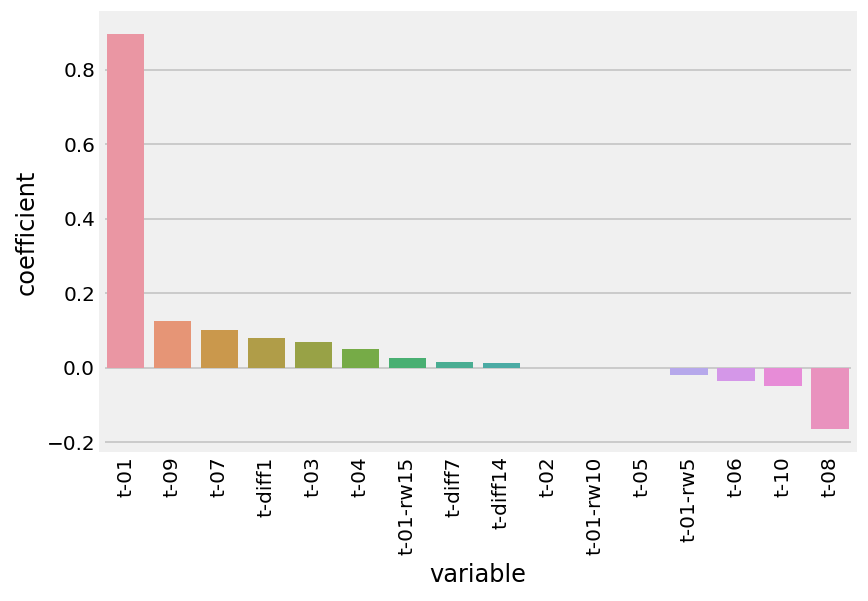

In [29]:
sns.barplot(x='variable', y='coefficient', data=lasso_coefficients)
plt.xticks(rotation=90)

The major contribution is give by the first lag give.

## Simple Forecasting Models
What would be the performance of a Naive approach that just predicts the current price using yesterday price? And what about the average over a previous period? Let's check it!

In [30]:
df_result_test = pd.DataFrame(y_test)
df_result_test['predicted (naive)'] = df_stock['t-01']
df_result_test['predicted (mean(5))'] = df_stock['t-01-rw5']
df_result_test['predicted (mean(10))'] = df_stock['t-01-rw10']

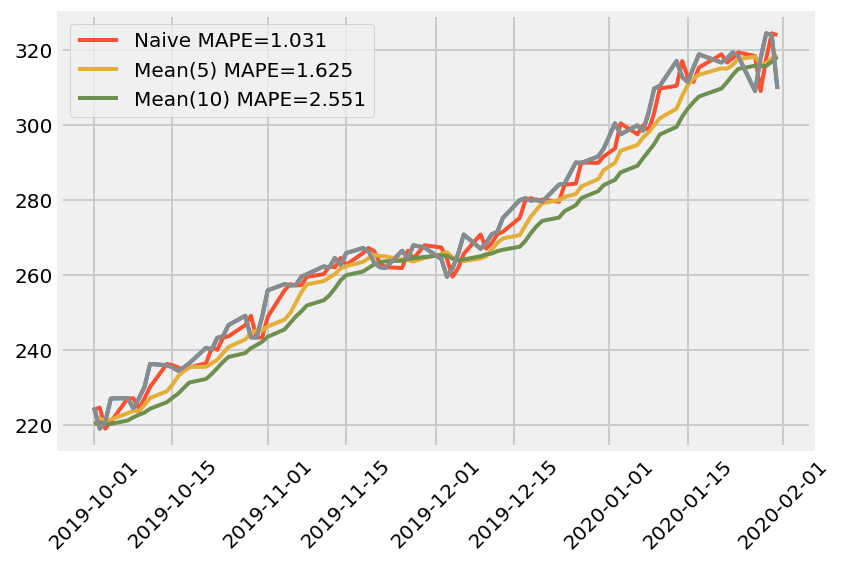

In [31]:
plt.plot(df_result_test['t']);
plt.plot(df_result_test['predicted (naive)'], 
         label="Naive MAPE=%.3f"%(mean_absolute_percentage_error(df_result_test['t'], df_result_test['predicted (naive)'])));
plt.plot(df_result_test['predicted (mean(5))'], 
         label="Mean(5) MAPE=%.3f"%(mean_absolute_percentage_error(df_result_test['t'], df_result_test['predicted (mean(5))'])));
plt.plot(df_result_test['predicted (mean(10))'], 
         label="Mean(10) MAPE=%.3f"%(mean_absolute_percentage_error(df_result_test['t'], df_result_test['predicted (mean(10))'])));
plt.plot(df_result_test['t']);
plt.xticks(rotation=45);
plt.title("");
plt.legend();

## Random Forests
Finally, we apply a random forest regressor using 500 trees.

In [35]:
forest = RandomForestRegressor(n_estimators=100, random_state=1)
forest.fit(X_train, y_train)

forest_yt = forest.predict(X_train)
forest_yp = forest.predict(X_test)

print('RMSE on Test %.3f'%math.sqrt(mean_squared_error(y_test, forest_yp)))
print('MAPE on Test %.3f'%mean_absolute_percentage_error(y_test, forest_yp))

RMSE on Test 36.852
MAPE on Test 9.236


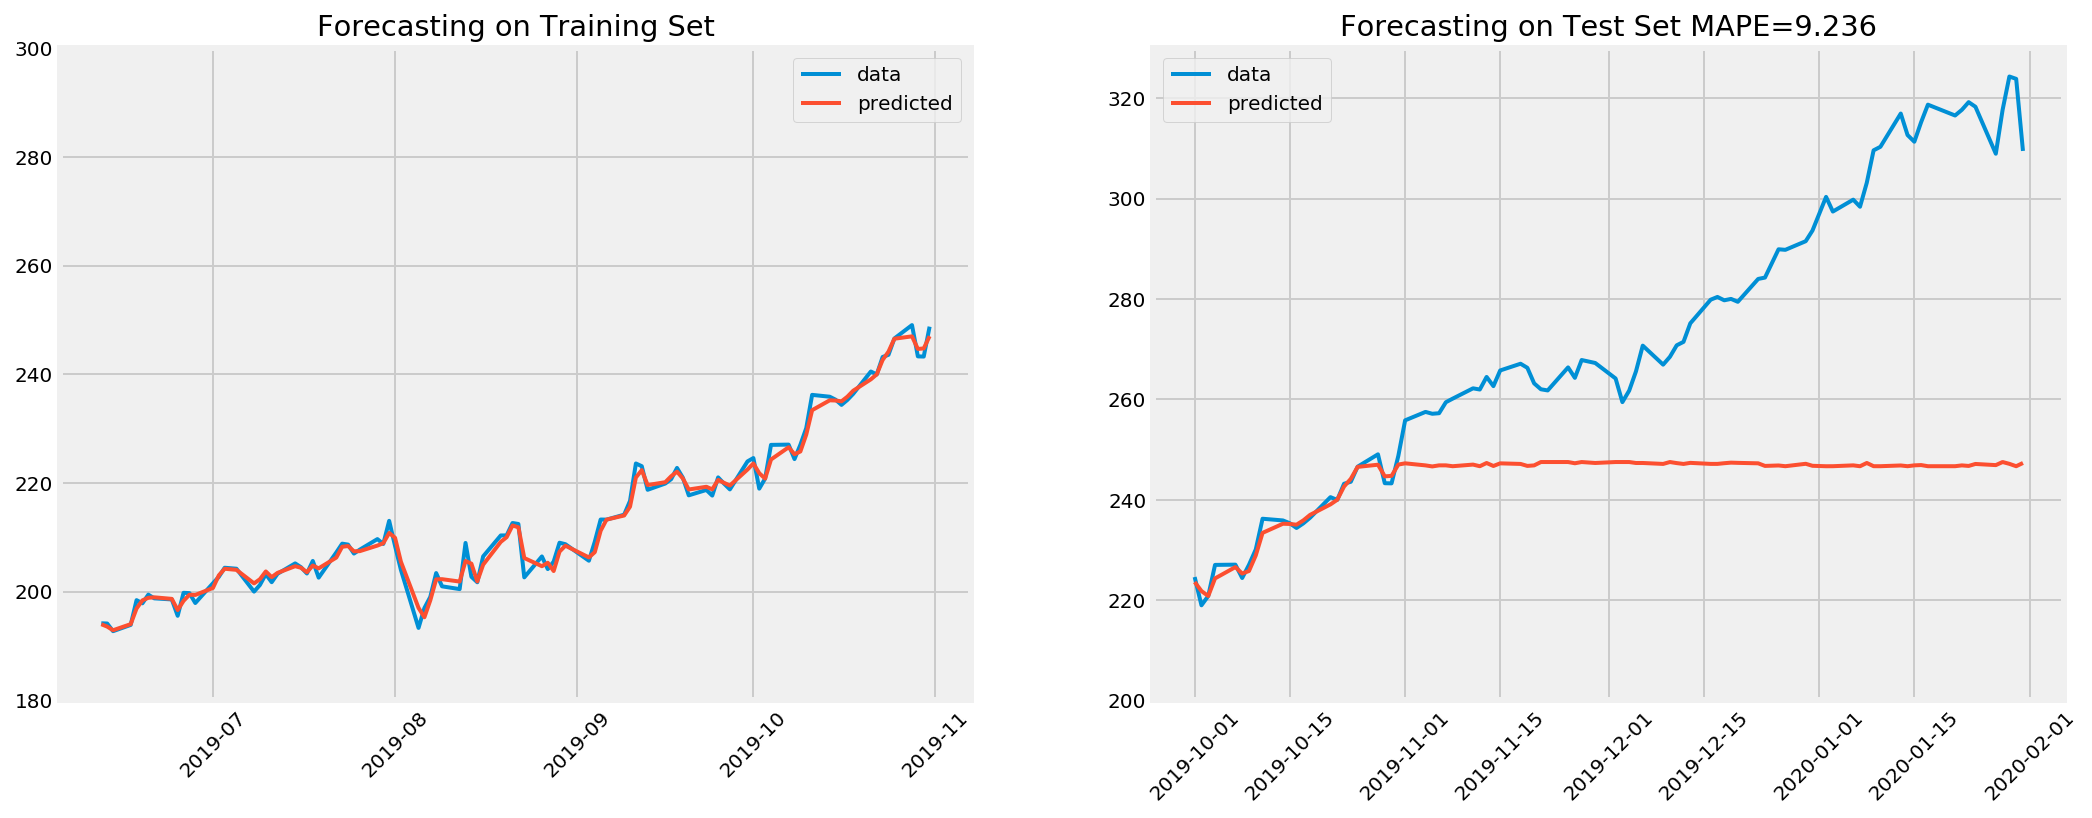

In [36]:
df_result_forest_train = pd.DataFrame(y_train)
df_result_forest_train['predicted'] = forest_yt
df_result_forest_test = pd.DataFrame(y_test)
df_result_forest_test['predicted'] = forest_yp

fig,axes = plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(df_result_forest_train['t'][-100:],label='data')
plt.plot(df_result_forest_train['predicted'][-100:],label='predicted')
plt.ylim([180,300])
plt.xticks(rotation=45)
plt.title("Forecasting on Training Set")
plt.legend();

plt.subplot(1,2,2)
plt.plot(df_result_forest_test['t'],label='data')
plt.plot(df_result_forest_test['predicted'],label='predicted')
plt.ylim([200,330])
plt.xticks(rotation=45)
plt.title("Forecasting on Test Set MAPE=%.3f"%mean_absolute_percentage_error(y_test, forest_yp))
plt.legend();

Why is this happening? Aren't random forests and all the ensemble methods very good at predicting? 

## Daily Returns

In [40]:
# create a data frame from a stock series
df_daily_returns = pd.DataFrame()
df_daily_returns['t'] = daily_returns['AAPL']

df_daily_returns = add_variables(df_daily_returns,'t',lags=10,diffs=[1,5,10],rolling_windows=[5,10,15])

In [41]:
target_variable = 't'
input_variables = df_daily_returns.columns[df_daily_returns.columns!=target_variable]

X = df_daily_returns[input_variables]
y = df_daily_returns[target_variable]

X_train, X_test = X['2017':'2019-10'], X['2019-10':]
y_train, y_test = y['2017':'2019-10'], y['2019-10':]

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

yt = lr_model.predict(X_train)
yp = lr_model.predict(X_test)

print('RMSE on Test %.3f'%math.sqrt(mean_squared_error(yp, y_test)))
print('MAPE on Test %.3f'%mean_absolute_percentage_error(y_test, yp))

RMSE on Test 0.013
MAPE on Test 132.292


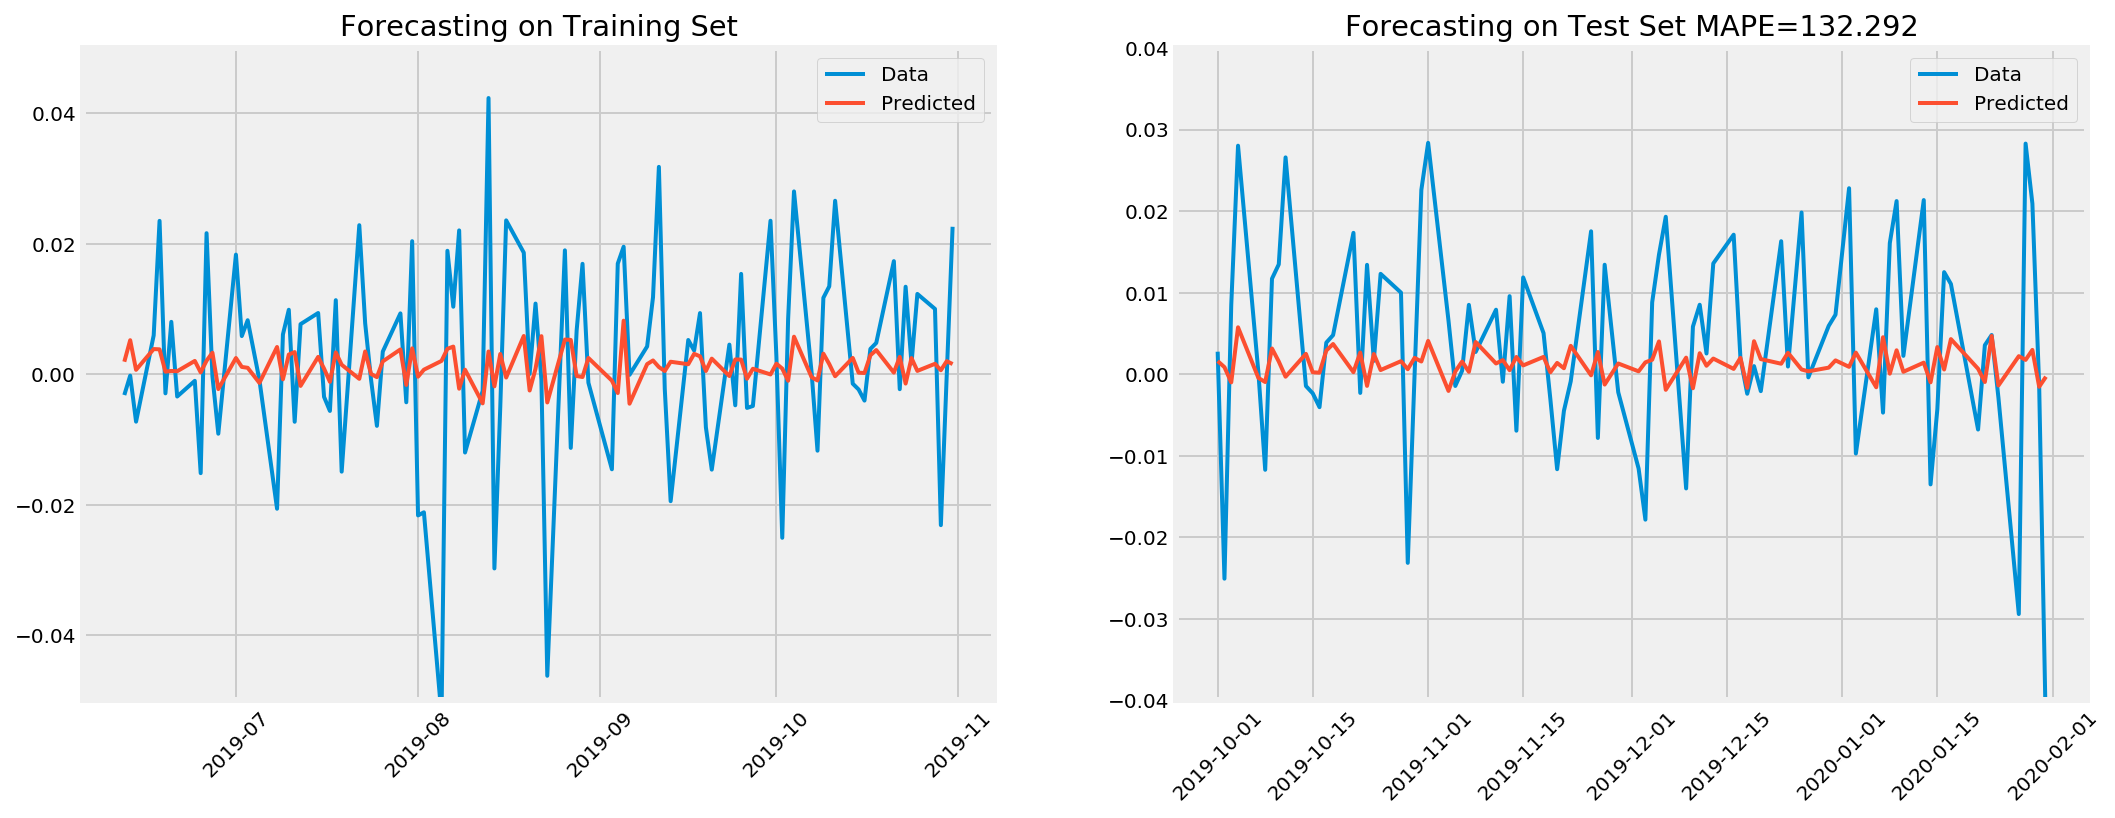

In [42]:
df_result_train = pd.DataFrame(y_train)
df_result_train['predicted'] = yt
df_result_test = pd.DataFrame(y_test)
df_result_test['predicted'] = yp

fig,axes = plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(df_result_train['t'][-100:],label='Data')
plt.plot(df_result_train['predicted'][-100:],label='Predicted')
plt.ylim([-0.05,0.05])
plt.xticks(rotation=45)
plt.title("Forecasting on Training Set")
plt.legend();

plt.subplot(1,2,2)
plt.plot(df_result_test['t'],label='Data')
plt.plot(df_result_test['predicted'],label='Predicted')
plt.ylim([-0.04,0.04])
plt.xticks(rotation=45)
plt.title("Forecasting on Test Set MAPE=%.3f"%mean_absolute_percentage_error(y_test,yp))
plt.legend();

In [43]:
forest = RandomForestRegressor(n_estimators=2000)
forest.fit(X_train, y_train)

forest_yt = forest.predict(X_train)
forest_yp = forest.predict(X_test)

print('RMSE on Test %.3f'%math.sqrt(mean_squared_error(y_test,forest_yp)))
print('MAPE on Test %.3f'%mean_absolute_percentage_error(y_test,forest_yp))

RMSE on Test 0.012
MAPE on Test 126.116


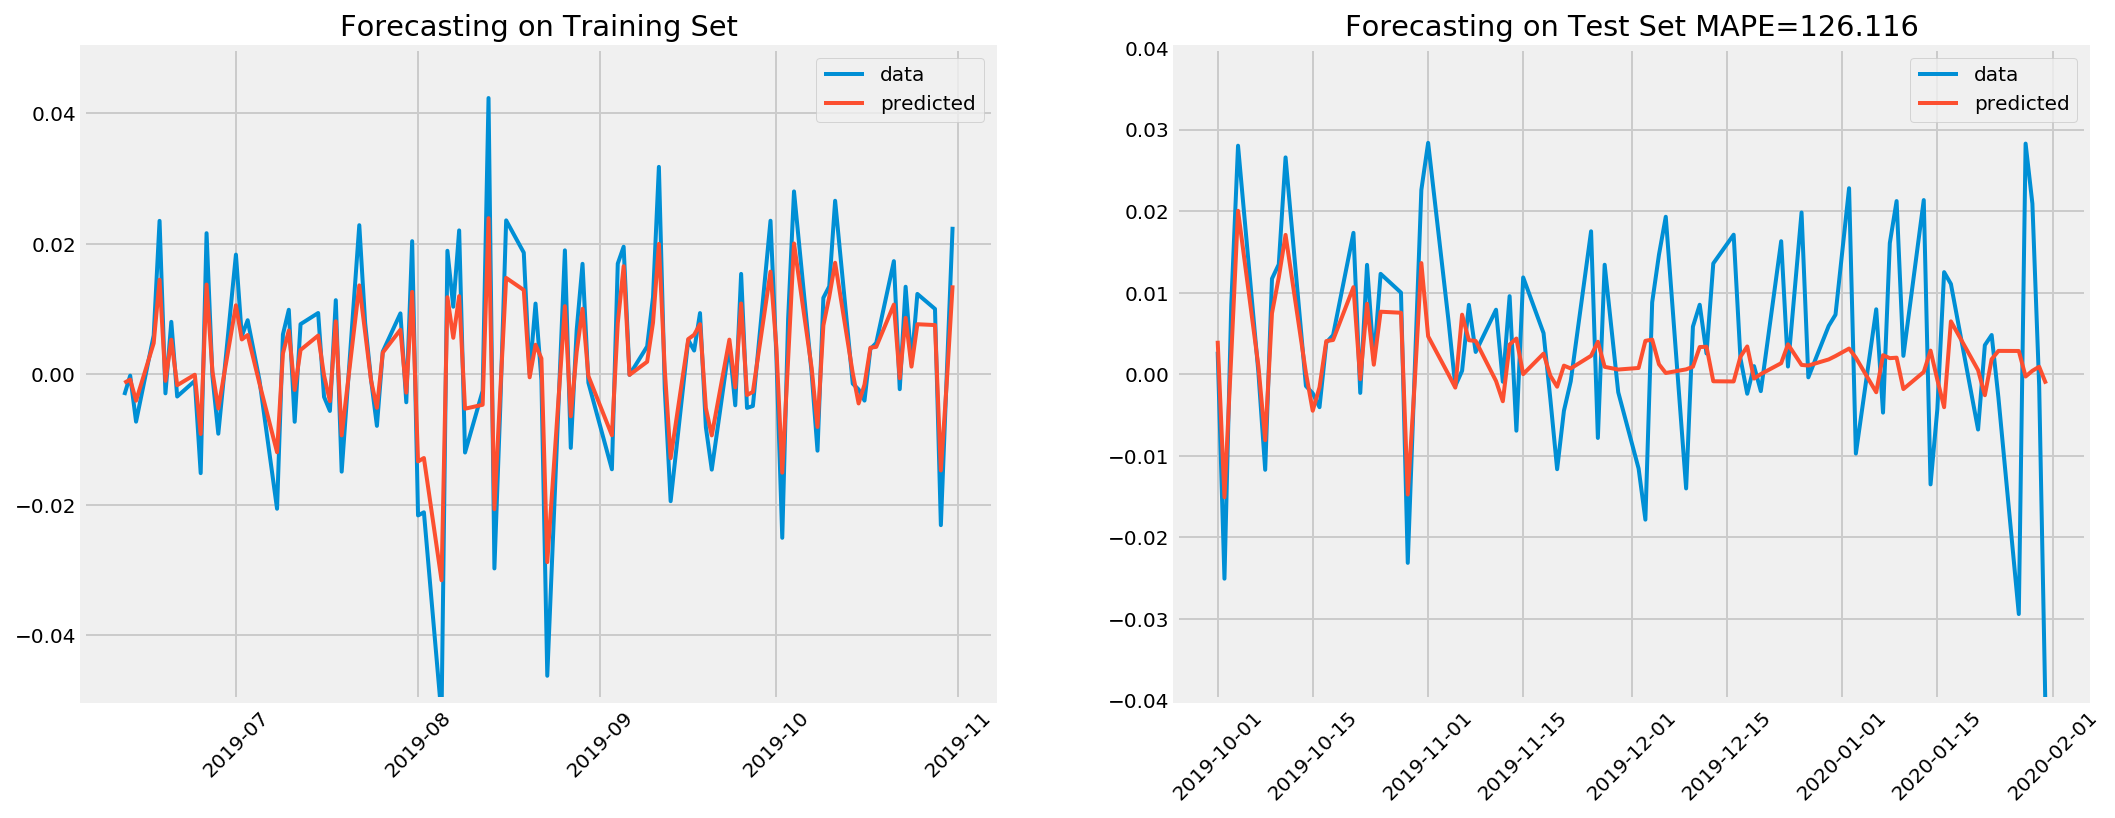

In [44]:
df_result_forest_train = pd.DataFrame(y_train)
df_result_forest_train['predicted'] = forest_yt
df_result_forest_test = pd.DataFrame(y_test)
df_result_forest_test['predicted'] = forest_yp

fig,axes = plt.subplots(1,2,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(df_result_forest_train['t'][-100:],label='data')
plt.plot(df_result_forest_train['predicted'][-100:],label='predicted')
plt.ylim([-0.05,0.05])
plt.xticks(rotation=45)
plt.title("Forecasting on Training Set")
plt.legend();

plt.subplot(1,2,2)
plt.plot(df_result_forest_test['t'],label='data')
plt.plot(df_result_forest_test['predicted'],label='predicted')
plt.ylim([-0.04,0.04])
plt.xticks(rotation=45)
plt.title("Forecasting on Test Set MAPE=%.3f"%mean_absolute_percentage_error(y_test,forest_yp))
plt.legend();

One interesting feature of random forests is that they return an index of feature importance that can be used both to have a better understanding of what influence the target values and but also for feature selection.

In [45]:
def PlotRFFeatureImportance(forest, feature_names, sort_importance=True):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    if (sort_importance):
        indices = np.argsort(importances)[::-1]
    else:
        indices = np.argsort(feature_names)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d %s (%f)" % (f + 1, indices[f], feature_names[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), feature_names[indices],rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

Feature ranking:
1. feature 4 t-05 (0.116375)
2. feature 2 t-03 (0.078156)
3. feature 7 t-08 (0.075076)
4. feature 13 t-01-rw5 (0.070173)
5. feature 6 t-07 (0.068741)
6. feature 5 t-06 (0.067317)
7. feature 14 t-01-rw10 (0.065731)
8. feature 3 t-04 (0.059266)
9. feature 8 t-09 (0.054717)
10. feature 1 t-02 (0.053533)
11. feature 9 t-10 (0.050485)
12. feature 12 t-diff10 (0.049835)
13. feature 0 t-01 (0.049190)
14. feature 11 t-diff5 (0.048291)
15. feature 10 t-diff1 (0.047854)
16. feature 15 t-01-rw15 (0.045263)


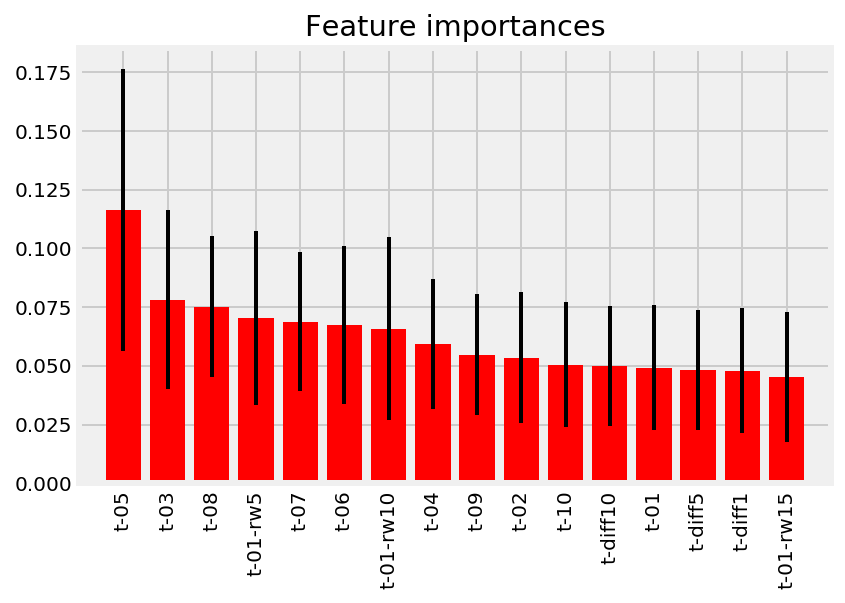

In [46]:
PlotRFFeatureImportance(forest,input_variables,True)

In [48]:
from pmdarima.arima import auto_arima
arima_model = auto_arima(daily_returns["AAPL"][:'2019-10'], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True,
                           d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

ModuleNotFoundError: No module named 'pmdarima'

In [39]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3481
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                7780.654
Date:                            Tue, 17 Nov 2020   AIC                         -15549.309
Time:                                    19:20:46   BIC                         -15512.401
Sample:                                         0   HQIC                        -15536.131
                                           - 3481                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7394      0.011    -64.609      0.000      -0.762      -0.717
ar.L2         -0.5288      0.013    -40.456      0.000      -0.554      -0.503
ar.L3         -0.2789      0.012    -23.973      0.000      -0.302      -0.256
ar.S.L12      -0.6459      0.012    -53.482      0.000      -0.670      -0.622
ar.S.L24      -0.3157      0.012    -25.848      0.000      -0.340      -0.292
sigma2         0.0007   9.51e-06     69.164      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                      696.74   Jarque-Bera (JB):              1997.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

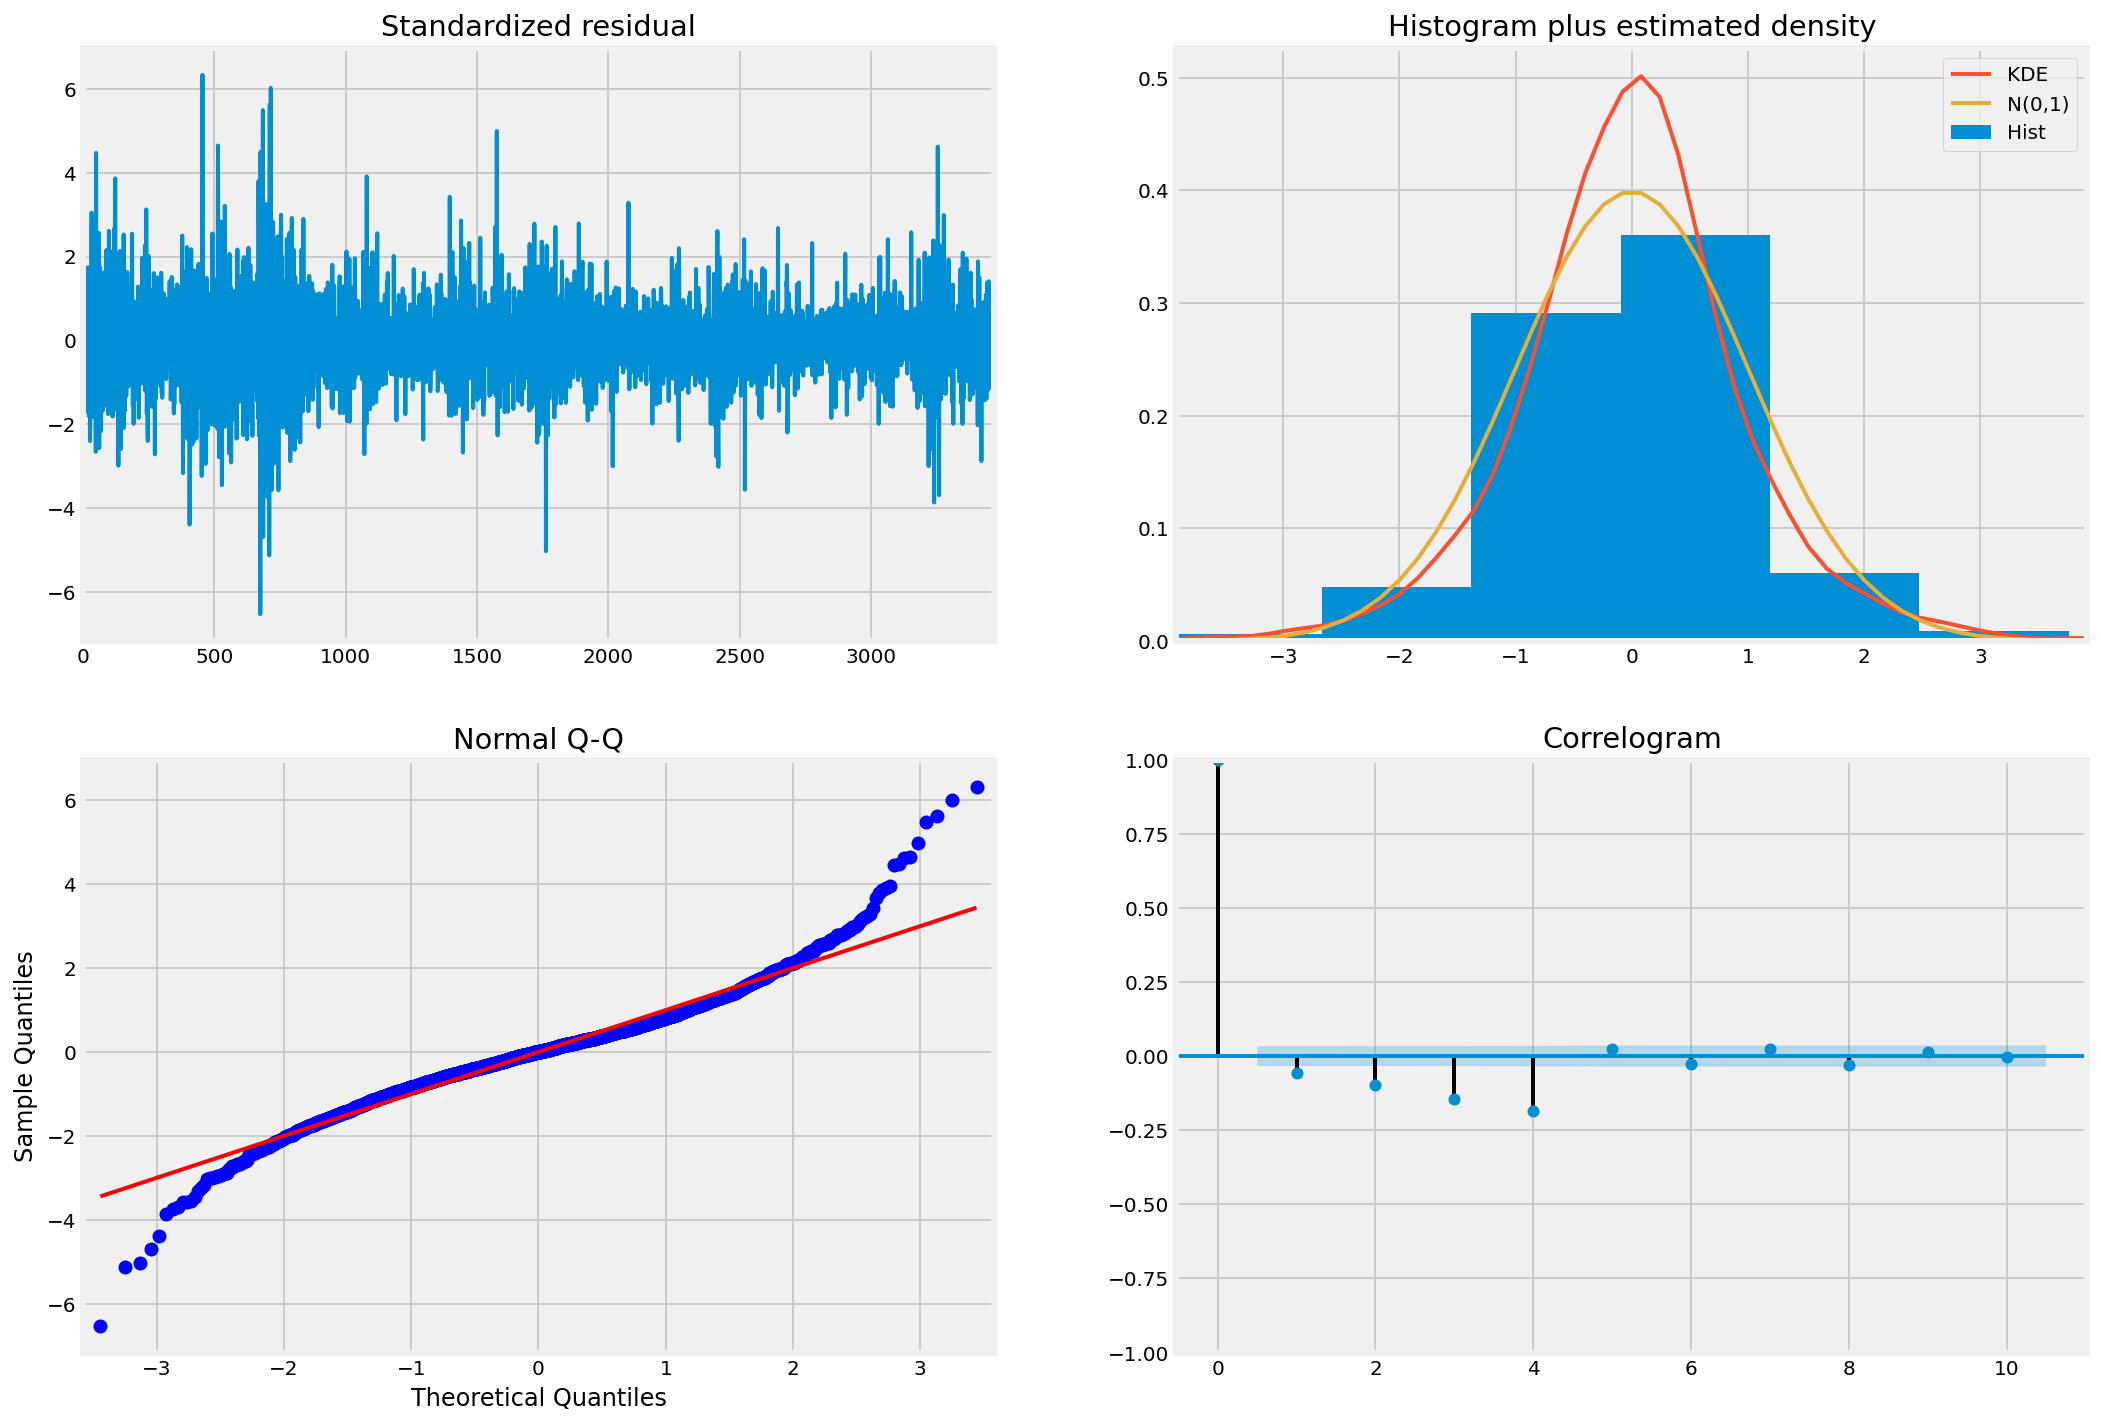

In [40]:
g = arima_model.plot_diagnostics(figsize=(16,12))

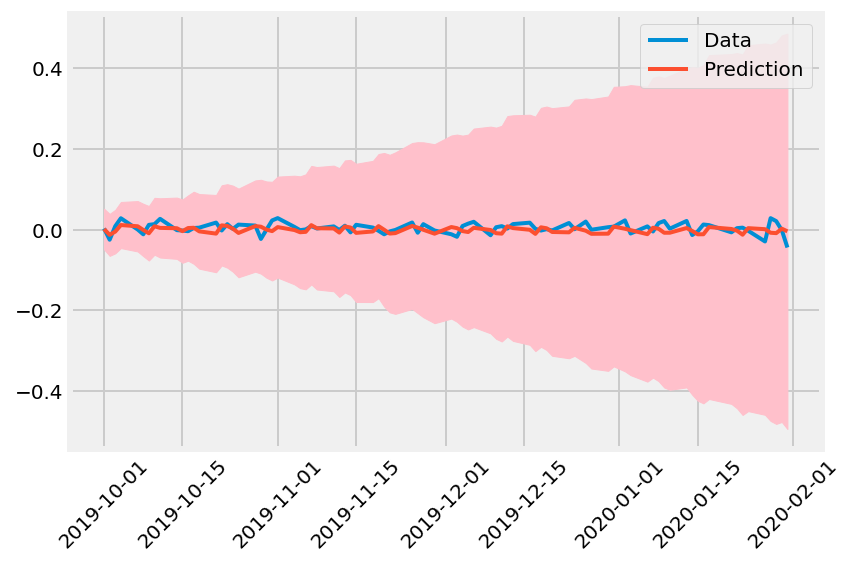

In [41]:
n_periods = y_test.shape[0]
arima_forecast, arima_confint = arima_model.predict(n_periods=n_periods, return_conf_int=True)

df_arima_forecast = pd.DataFrame(arima_forecast, index = y_test.index, columns=["AAPL"])

plt.plot(y_test, label='Data')
plt.plot(df_arima_forecast, label='Prediction');
plt.fill_between(y_test.index, arima_confint[:,0],arima_confint[:,1], color='pink');
plt.xticks(rotation=45)
plt.legend();